# Image classification

### Neccesary **libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import keras
import tensorflow as tf
from keras import regularizers

In [2]:
from tensorflow.keras.layers import Input,Dense,Conv2D,Dropout,MaxPool2D,concatenate,Flatten,BatchNormalization, GlobalAvgPool2D
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from keras.datasets import cifar10
from keras.optimizers import Adam

In [3]:
 !pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 5.8MB/s 


### Dataset **cifar10** from kerss

In [4]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 4s 0us/step


### Data Processesing and train and val set generation

In [5]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3,shuffle=True)

In [6]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))
print((x_test.shape,y_test.shape))

((35000, 32, 32, 3), (35000, 1))
((15000, 32, 32, 3), (15000, 1))
((10000, 32, 32, 3), (10000, 1))


In [7]:
y_train = y_train.tolist()
y_train = np.array(y_train).reshape(35000,)

In [8]:
img_1 = x_train[y_train==1]
img_2 = x_train[y_train==2]
img_0 = x_train[y_train==0]
img_4 = x_train[y_train==4]
img_5 = x_train[y_train==5]
img_6 = x_train[y_train==6]

In [9]:
n1,n2,n0,n4,n5,n6=img_1.shape[0],img_2.shape[0],img_0.shape[0],img_4.shape[0],img_5.shape[0],img_6.shape[0]
y_train = np.array([1]*n1 + [2]*n2 + [0]*n0 + [4]*n4 + [5]*n5 + [6]*n6)
y_train.shape

(21081,)

In [10]:
x_train= np.concatenate([img_1,img_2,img_0,img_4,img_5,img_6] ,axis=0)
x_train.shape

(21081, 32, 32, 3)

In [11]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.3,shuffle=True)

In [12]:
x_train = x_train/255
x_val =x_val/255

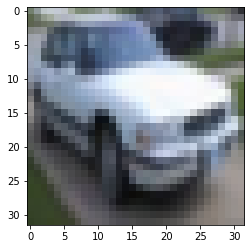

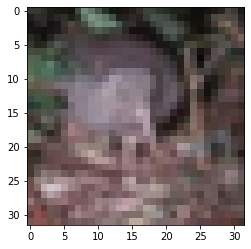

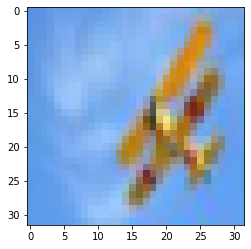

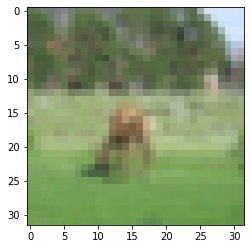

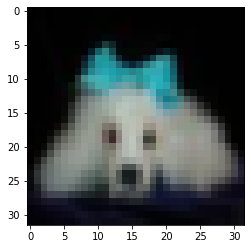

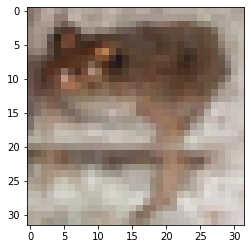

In [13]:
plt.imshow(img_1[1])
plt.show()
plt.imshow(img_2[2])
plt.show()
plt.imshow(img_0[0])
plt.show()
plt.imshow(img_4[1])
plt.show()
plt.imshow(img_5[1])
plt.show()
plt.imshow(img_6[1])
plt.show()

In [14]:
print((x_train.shape,y_train.shape))
print((x_val.shape,y_val.shape))

((14756, 32, 32, 3), (14756,))
((6325, 32, 32, 3), (6325,))


#### Generating OneHotEncoding for numbers

In [15]:
num_2_onehot = OneHotEncoder()
y_train_onehot= num_2_onehot.fit_transform(y_train.reshape(14756,1))
y_val_onehot = num_2_onehot.transform(y_val.reshape(6325,1))

y_train_onehot=y_train_onehot.toarray()
y_val_onehot=y_val_onehot.toarray()

In [16]:
y_val_onehot.shape,y_train_onehot.shape

((6325, 6), (14756, 6))

### Building a **Keras model** with **Keras tuner**

In [17]:
import tensorflow as tf
from tensorflow import keras
import kerastuner as kt

In [18]:
def regu(type,value):
    return regularizers.l1( value ) if type == 'l1' else regularizers.l2( value )

In [19]:
def model_builder(hp):
    # regular = regu(hp.Choice('type', values=['l1','l2']),hp.Choice('value', values=[0.05,0.1,0.01,0.001]))
    model = keras.Sequential()
    model.add(Conv2D(filters=hp.Int('conv1', min_value=32, max_value=128, step=32), kernel_size=3 , padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(MaxPool2D((2,2)))
    model.add(Conv2D(filters=hp.Int('conv2', min_value=64, max_value=128, step=32), kernel_size=3 , activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Choice('Dropout1', values=[0.2,0.3])))
    model.add(Conv2D(filters=hp.Int('conv3', min_value=64, max_value=160, step=32), kernel_size=3 , activation='relu'))
    model.add(BatchNormalization())
    # model.add(MaxPool2D((2,2)))
    model.add(Conv2D(filters=hp.Int('conv4', min_value=32, max_value=128, step=32), kernel_size=3 , activation='relu'))
    model.add(BatchNormalization())
    model.add(GlobalAvgPool2D())
    model.add(Dropout(rate=hp.Choice('Dropout2', values=[0.2,0.1,0.0])))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # hp_units = hp.Int('units', min_value=32, max_value=64, step=8)
    for j in range(3):
        model.add(keras.layers.Dense(units= hp.Int('Dense_'+str(j), min_value=32, max_value=64, step=8), activation='relu',
                                     kernel_regularizer = regu(hp.Choice('type'+str(j), values=['l1','l2']),hp.Choice('value'+str(j), values=[0.05,0.1,0.01,0.001]))))
        model.add(BatchNormalization())
        if j!=2:
            model.add(Dropout(0.1))

    model.add(keras.layers.Dense(6, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    # print(model.summary())

    return model

In [21]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt1')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(x_train, y_train_onehot, epochs=15, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 30 Complete [00h 17m 23s]
val_accuracy: 0.6144986152648926

Best val_accuracy So Far: 0.6876693964004517
Total elapsed time: 02h 24m 44s
INFO:tensorflow:Oracle triggered exit


#### Getting best **weights** and **model** from the **Keras Tunner**

In [26]:
model = tuner.hypermodel.build(best_hps)

callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True)

model.summary()
history = model.fit(x_train, y_train_onehot, epochs=50, batch_size=40, validation_split=0.2,callbacks=[callback], shuffle=True)

val_loss_per_epoch = history.history['val_loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 128)       3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        73792     
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       5

#### saving the model

In [28]:
# !rm -rf /content/my_dir
model.save('final_model_1_reg.h5')

#### ***Evaluvating the model on test data***
but we names test data as val 
and vallidation is done by spliting portion of training data using validation_split in fit function

In [27]:
model.evaluate(x_val,y_val_onehot)

198/198 [==============================] - 7s 37ms/step - loss: 0.7855 - accuracy: 0.7529


[0.785476803779602, 0.7528854012489319]